In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.signal import find_peaks
from tqdm import tqdm
import h5py
from multiprocessing import Pool

import pickle
import gzip
from matplotlib import rc
import warnings

plt.style.use('seaborn-v0_8-white')
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
warnings.filterwarnings("ignore")

In [3]:
# Simulation params
vi = 0.01
Vol = vi*10**(-14); NA = 6.02*10**(23); Cal = NA*Vol*10**(-6)
TC = 0.158
kc1 = 0.15*Cal*TC
# production of p53 [molecules/min]
kc2 = 0.1*TC
# degradation of p53 by mdm2 [1/min]
kc3 = 0.1*Cal
# degradation of p53 by mdm2 [molecules]
kc4 = 0.1/Cal*TC
# production of mdm2 - mRNA [1/(molecules*min)]
kc5 = 0.1*TC 
# degradation of mdm2 - mRNA [1/min]
kc6 = 0.2*TC 
# production of mdm2 [1/min]
kc7 = 0.1*TC 
# degradation of mdm2 [1/min]
kc8 = 0.0036 
# binding of mdm2 and nutlin [1/(molecules*min)]

p_transient, m_transient, Mf_transient, Mb_transient = (68.7677614186749, 39.447611187479886, 62.52296546950754, -1.4584740455754785e-07)
T_int, A_int = (329.1125843870209, 32.35464308364189) # These are from the initial conditions found in "Nutlin-tilføjelse.ipynb" so we don't have to run a new transient every time.

In [4]:
# Equations
def p_change(t, p, m, Mf, Mb, n):
    dpdt = kc1 - kc2*Mf*(p / (kc3 + p))
    return dpdt

def m_change(t, p, m, Mf, Mb, n):
    dmdt = (kc4 * p**2 - kc5 * m)
    return dmdt

def M_free_change(t, p, m, Mf, Mb, n):
    dM_freedt = kc6 * m - kc7 * Mf - kc8*n*Mf
    return dM_freedt

def M_bound_change(t, p, m, Mf, Mb, n):
    dM_bounddt = - kc7*Mb + kc8*n*Mf
    return dM_bounddt

def n_change(t, p, m, Mf, Mb, n):
    dndt = -kc8*n*Mf
    return dndt

def samlet_system(t, y):
    dydt = np.zeros_like(y)
    dydt[0] = p_change(t, *y)
    dydt[1] = m_change(t, *y)
    dydt[2] = M_free_change(t, *y)
    dydt[3] = M_bound_change(t, *y)
    dydt[4] = n_change(t, *y)
    return dydt

In [5]:
def sim_onoff_nutlin(oscillationer, OOmega, A_ext):
    # This is correct, and it is working! Remember to count in period values, not frequency! If you count in frequency, you are counting the reciprocal.
    T_ext = OOmega * T_int
    theoretical_small_omega = T_int / T_ext # Is this correct?

    history = {"t":[] ,"p": [], "m": [], "Mf": [], "Mb":[], "n":[]}

    for i in range(oscillationer):
        if i == 0:
            state = p_transient, m_transient, Mf_transient, Mb_transient, A_ext
            sys = solve_ivp(samlet_system, (0, T_ext), state, method='RK45', max_step=5, dense_output=True)
            t, p, m, Mf, Mb, n = np.array(sys["t"]), sys["y"][0], sys["y"][1], sys["y"][2], sys["y"][3], sys["y"][4]
            history["t"].extend(t)
            history["p"].extend(p)
            history["m"].extend(m)
            history["Mf"].extend(Mf)
            history["Mb"].extend(Mb)
            history["n"].extend(n)
        
        # Every period, Nutlin concentration is reset to A_ext
        state = history["p"][-1], history["m"][-1], history["Mf"][-1], history["Mb"][-1], A_ext
        sys = solve_ivp(samlet_system, (0, T_ext), state, method='RK45', max_step=5, dense_output=True)
        t, p, m, Mf, Mb, n = np.array(sys["t"]), sys["y"][0], sys["y"][1], sys["y"][2], sys["y"][3], sys["y"][4]
        history["t"].extend(t + history["t"][-1])
        history["p"].extend(p)
        history["m"].extend(m)
        history["Mf"].extend(Mf)
        history["Mb"].extend(Mb)
        history["n"].extend(n)
    
    return history, theoretical_small_omega, T_ext

In [6]:
# Takes in arrays with Omegas and Coupling Strengths to simulate with
def arnold_tongue_simulering(omega_list, coupling_strength_list, A_ext_list):
    # All the tongues which we are interested in
    all_tongues = [0.5, 1, 1.5, 2]

    # A dictionary for storing the simulations
    arnold_tongue_dict = {"Tongue": [], "Omega": [], "coupling_strength": [], "A_ext":[], "entrainment_value":[], "exception": []}

    # Run simulation for all combinations
    for i in tqdm(range(len(omega_list))):
        for j in range(len(A_ext_list)):
            oscillationer = 200

            simulation, _, _ = sim_onoff_nutlin(oscillationer, omega_list[i], A_ext_list[j])
            _, p_sim, _, _, _, n_sim = np.array(simulation["t"]), np.array(simulation["p"]), np.array(simulation["m"]), np.array(simulation["Mb"]), np.array(simulation["Mf"]), np.array(simulation["n"])

            # Apply a small window and require peak higher than mean
            window = 500
            peaks_internal = len(find_peaks(p_sim[window:], height=np.mean(p_sim))[0])
            peaks_external = len(find_peaks(n_sim[window:], height=np.mean(n_sim))[0])
            
            Omega_ratio = 0
            exception = False
            
            # If for some reason this fraction throws an error, we log it instead of the simulation just crashing
            try:
                # 1/Omega because we are using frequency, which is 1/T
                Omega_ratio = peaks_internal/peaks_external
            except:
                exception = True

            # We chose this as our accuracy to begin with, but it seems like we are getting results which resembles the ground "truth", so we are happy with it so far
            rounded_ratio = np.round(Omega_ratio, 2)

            entrainment = 0 # Corresponds to no entrainment

            # Arbritrary threshold, we hope it works. But it is symmetric here, so we don't understand why the entrainment is shifted.
            for tongue_value in all_tongues:
                if tongue_value - 1e-2 <= rounded_ratio <= tongue_value + 1e-2:
                    entrainment = tongue_value

            # DEBUGGING PRINTS
            # print(rounded_ratio)
            # print("Current Omega: ", omega_list[i])
            # print("Current Nutlin Amplitude: ", A_ext_list[j])
            # print("Entrainment: ", entrainment)

            arnold_tongue_dict["Omega"].append(omega_list[i])
            arnold_tongue_dict["coupling_strength"].append(coupling_strength_list[j])
            arnold_tongue_dict["A_ext"].append(A_ext_list[j])
            arnold_tongue_dict["entrainment_value"].append(entrainment)
            arnold_tongue_dict["exception"].append(exception)
    
    return arnold_tongue_dict


# Til enkelte tests

In [108]:
antal_omegaer = 20

omega_list = np.array(np.linspace(0.01, 2.5, antal_omegaer))
# tounge_one = np.array(np.linspace(0.75, 1.24, antal_omegaer))
# tounge_three_halves = np.array(np.linspace(1.25, 1.74, antal_omegaer))
# tounge_two = np.array(np.linspace(1.75, 2.25, antal_omegaer))
# omega_list = np.concatenate((tounge_half, tounge_one, tounge_three_halves, tounge_two))

antal_A_ext = 20
coupling_strengths = np.array(np.linspace(0.3, 5, antal_A_ext))
A_ext_list = coupling_strengths * A_int # A_ext = A_int * coupling strenght

resolution = f'{antal_omegaer}x{antal_A_ext}'

antal_simulationer_arnold = len(omega_list) * antal_A_ext
print("Det ønskede antal simulationer er:", antal_simulationer_arnold)
print("Key: ", resolution)

Det ønskede antal simulationer er: 400
Key:  20x20


In [ ]:
arnold_dict = arnold_tongue_simulering(omega_list, coupling_strengths, A_ext_list)

# Nyt loading

In [7]:
def load_data(filename):
    with gzip.open(filename, 'rb') as f:
        data = pickle.load(f)
    return data

# Example usage
loaded_data = load_data('arnold_sims/arnold_tongue_dict_latest.pkl.gz')
# Now you can use 'loaded_data' for plotting or analysis

In [18]:
Omegas_tested = loaded_data["Omega"]
Coupling_strengths_tested = loaded_data["coupling_strength"]
A_ext_tested = loaded_data["A_ext"]
Entrainments = loaded_data["entrainment_value"]
Exceptions = loaded_data["exception"]

color_map = [
    'C0' if entrainment == 0.5 else
    'C1' if entrainment == 1 else
    'C2' if entrainment == 1.5 else
    'C6' if entrainment == 2 else
    'red' if Exceptions[i] == True else
    'gray'
    for i, entrainment in enumerate(Entrainments)
]



2500

Text(0.5, 0, 'External / Internal Period')

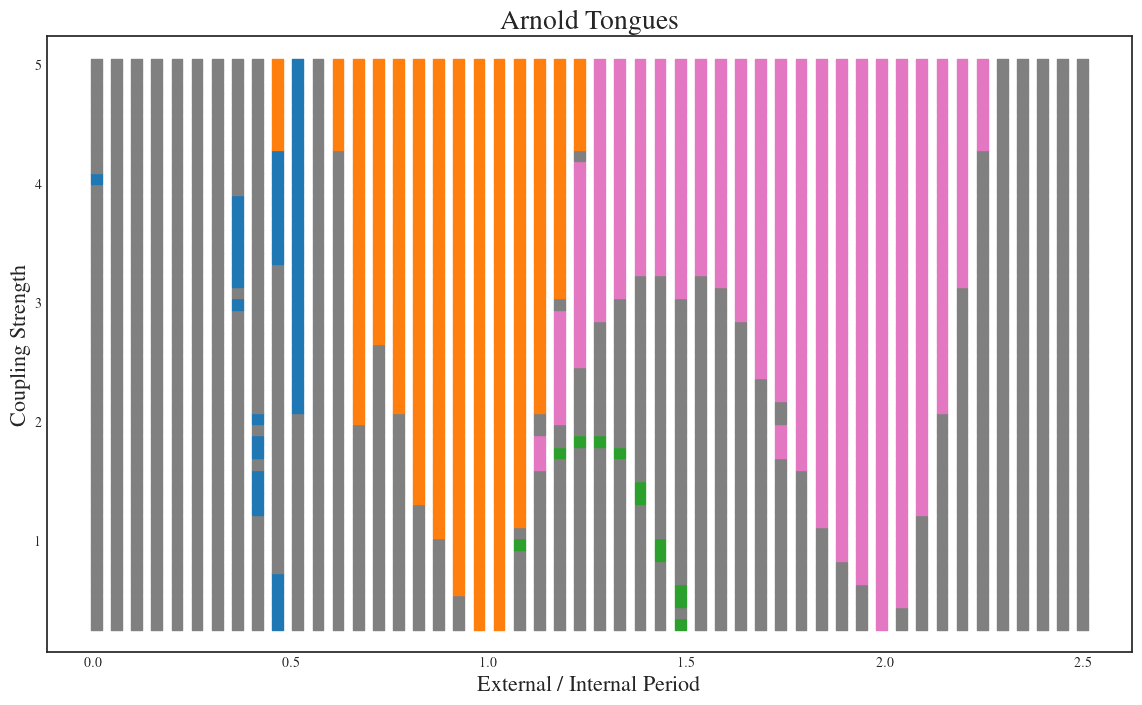

In [16]:
plt.figure(figsize=(14,8))

plt.scatter(Omegas_tested, Coupling_strengths_tested, c=color_map, s=60, marker="s")

plt.title("Arnold Tongues", fontsize=20)
plt.ylabel("Coupling Strength", fontsize=16)
plt.xlabel("External / Internal Period", fontsize=16)